In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sqlite3
import seaborn as sns
from dataclasses import dataclass, field
from typing import Dict, Tuple, Iterable
from Utils.Plot_Helper import plot_1d_data, plot_gaussian_node
from Utils.Metrics import rmse, nll, node_metrics
from Filters.KalmanFilter import KalmanFilterSmoother
from Systems import UniformNonlinearGrowthModel, BearingsOnlyTracking, BearingsOnlyTrackingTurn
from MomentMatching.Estimator import Estimator
from MomentMatching import UnscentedTransform, MonteCarloTransform, TaylorTransform
from ExpectationPropagation.Nodes import build_nodes, node_estimator, node_system
from ExpectationPropagation.Iterations import ep_iterations
from Experiments.FullSweep import select_transform

In [2]:
def select_data(experiment):
    if experiment == 'ungm':
        exp_table = 'UNGM_EXP'
        con = sqlite3.connect("../Experiments/ungm_final_2.db", detect_types=sqlite3.PARSE_DECLTYPES)
    elif experiment == 'bot':
        exp_table = 'BOT_EXP'
        con = sqlite3.connect("../Experiments/bot_final_2.db", detect_types=sqlite3.PARSE_DECLTYPES)
    elif experiment == 'bott':
        exp_table = 'BOTT_EXP'
        con = sqlite3.connect("../log/bott_final.db", detect_types=sqlite3.PARSE_DECLTYPES)

    cursor = con.cursor()
    return exp_table, cursor


def plot_ep_vs_kalman(cursor, filter_result, smoother_result, seed=101, table_name='UNGM_EXP', trans_id='TT', metric='rmse'):
    assert metric in ['rmse', 'nll'], 'metric must be one of (rmse, nll)'
    metric_ = rmse if metric == 'rmse' else nll
    query_str = "SELECT {} FROM {} WHERE Transform='{}' AND Seed={} AND Power=1.0 AND Damping=1.0"
    data = cursor.execute(query_str.format(metric, table_name, trans_id, seed)).fetchall()
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    ax = plot_1d_data(np.array(data).T, c="C3", label="EP", linewidth=2.5, figsize=(8,5))
    ax.axhline(metric_(filter_result, x_noisy), c="darkorchid", ls='--', linewidth=2.5, label="UKF")
    ax.axhline(metric_(smoother_result, x_noisy), c="c", ls='--', linewidth=2.5, label="UKS")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    return ax


def plot_power_ep_comparison(cursor, power_list, damping_list, seed=101, table_name='UNGM_EXP', trans_id='TT', metric='rmse', colors=['C3', 'yellowgreen', 'grey']):
    assert metric in ['rmse', 'nll'], 'metric must be one of (rmse, nll)'
    query_str = "SELECT {} FROM {} WHERE Transform='{}' AND Seed={} AND Power={} AND Damping={}"
    labels = [r'EP ($\alpha={}, \gamma={}$)', r'EP with damping ($\alpha={}, \gamma={}$)', r'Power EP with damping ($\alpha={}, \gamma={}$)']
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    ax = None
    for i, params in enumerate(zip(power_list, damping_list)):
        power, damp = params
        data = cursor.execute(query_str.format(metric, table_name, trans_id, seed, power, damp)).fetchall()
        label = labels[i].format(power, damp)
        ax = plot_1d_data(np.array(data).T, label, colors[i], ax=ax, linewidth=2.5, figsize=(8,5))

    ax.set_xlim(1, 50)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
        
    return ax

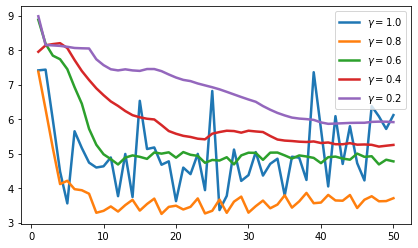

In [6]:
seed = 801
trans = 'UT'
experiment = 'ungm'
metric = 'RMSE'
exp_table, cursor = select_data(experiment)
fig = plt.figure(figsize=(7,4))
ax = fig.gca()
for damp in [1.0, 0.8, 0.6, 0.4, 0.2]:
    query_str = "SELECT {} FROM {} WHERE Transform='{}' AND Seed={} AND Power=1.0 AND Damping={}"
    data = cursor.execute(query_str.format(metric, exp_table, trans, seed, damp)).fetchall()
    ax = plot_1d_data(np.array(data).T, label=fr"$\gamma={damp}$", linewidth=2.5, figsize=(8,5), ax=ax)
plt.legend()

In [7]:
seed = 801
trans = 'UT'
experiment = 'ungm'
exp_table, cursor = select_data(experiment)

# TODO: Resolve issue with loading data from simulation table
np.random.seed(seed=seed)
if experiment == 'ungm':   
    system = UniformNonlinearGrowthModel()
    timesteps = 100
    sys_dim = 1
elif experiment == 'bot':
    system = BearingsOnlyTracking()
    timesteps = 50
    sys_dim = 4
elif experiment == 'bott':
    system = BearingsOnlyTrackingTurn()
    timesteps = 50
    sys_dim = 5

data = system.simulate(timesteps)
x_true, x_noisy, y_true, y_noisy = zip(*data)

# Get results from Kalman filter/smoother
transform, meas_transform = select_transform(trans, sys_dim, samples=int(1e4))
f = KalmanFilterSmoother(transform, system, meas_transform)
filter_result = f.kalman_filter(y_noisy)
smoother_result = f.kalman_smoother(filter_result)

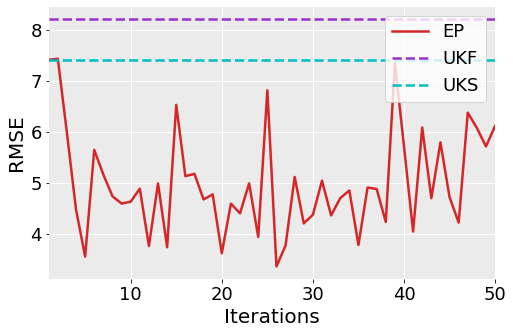

In [43]:
ax = plot_ep_vs_kalman(cursor, filter_result, smoother_result, seed=seed, table_name=exp_table, trans_id=trans)
plt.legend(loc='upper right', fontsize=18)
ax.set_xlim(1, 50)
ax.set_xlabel("EP Iterations", fontsize=20)
ax.set_ylabel("RMSE", fontsize=20)
plt.savefig(f"figs/EP_Kalman_comparison_{trans}_{seed}_RMSE.pdf", bbox_inches='tight')

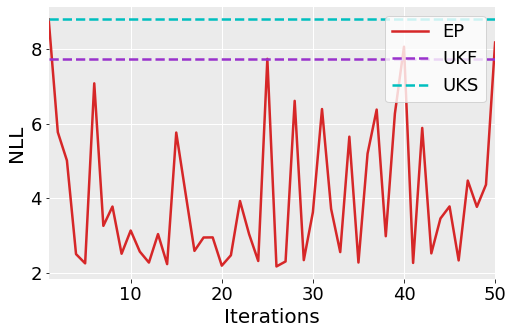

In [44]:
ax = plot_ep_vs_kalman(cursor, filter_result, smoother_result, metric='nll', seed=seed, table_name=exp_table, trans_id=trans)
plt.legend(loc='upper right', fontsize=18)
ax.set_xlim(1, 50)
#ax.set_ylim(1.8, 9.5)
ax.set_xlabel("Iterations", fontsize=20)
ax.set_ylabel("NLL", fontsize=20)
plt.savefig(f"figs/EP_Kalman_comparison_{trans}_{seed}_NLL.pdf", bbox_inches='tight')

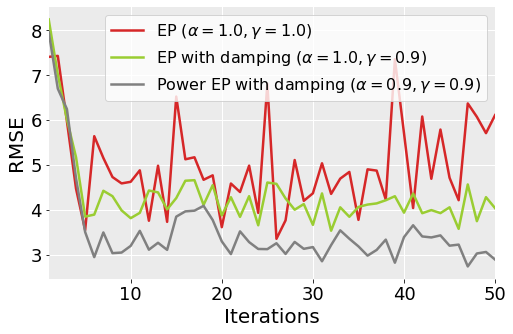

In [14]:
power_list = [1.0, 1.0, 0.9]
damping_list = [1.0, 0.9, 0.9]
ax = plot_power_ep_comparison(cursor, power_list, damping_list, seed=seed, table_name=exp_table, trans_id=trans, metric='rmse')
plt.legend(loc='upper right', fontsize=16)
ax.set_xlabel("Iterations", fontsize=20)
ax.set_ylabel("RMSE", fontsize=20)
plt.savefig(f"figs/Power_EP_comparison_{trans}_{seed}_RMSE.pdf", bbox_inches='tight')

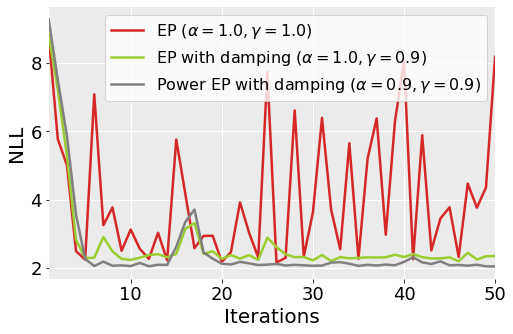

In [15]:
ax = plot_power_ep_comparison(cursor, power_list, damping_list, seed=seed, table_name=exp_table, trans_id=trans, metric='nll')
plt.legend(loc='upper right', fontsize=16)
ax.set_xlabel("Iterations", fontsize=20)
ax.set_ylabel("NLL", fontsize=20)
plt.savefig(f"figs/Power_EP_comparison_{trans}_{seed}_NLL.pdf", bbox_inches='tight')

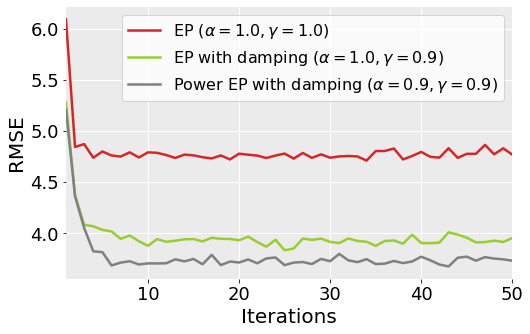

In [16]:
trans = 'MCT'
ax = plot_power_ep_comparison(cursor, power_list, damping_list, seed=seed, table_name=exp_table, trans_id=trans, metric='rmse')
plt.legend(loc='upper right', fontsize=16)
ax.set_xlabel("Iterations", fontsize=20)
ax.set_ylabel("RMSE", fontsize=20)
plt.savefig(f"figs/Power_EP_comparison_{trans}_{seed}_RMSE.pdf", bbox_inches='tight')

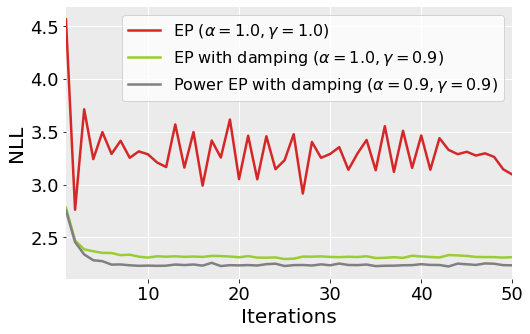

In [17]:
ax = plot_power_ep_comparison(cursor, power_list, damping_list, seed=seed, table_name=exp_table, trans_id=trans, metric='nll')
plt.legend(loc='upper right', fontsize=16)
ax.set_xlabel("Iterations", fontsize=20)
ax.set_ylabel("NLL", fontsize=20)
plt.savefig(f"figs/Power_EP_comparison_{trans}_{seed}_NLL.pdf", bbox_inches='tight')

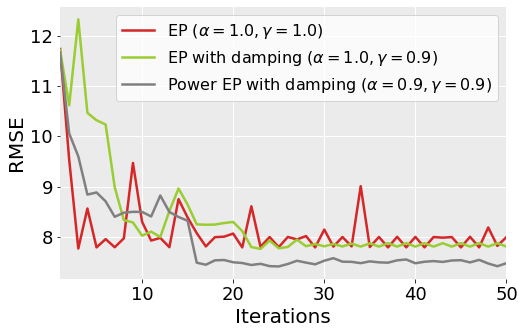

In [18]:
trans = 'TT'
ax = plot_power_ep_comparison(cursor, power_list, damping_list, seed=seed, table_name=exp_table, trans_id=trans, metric='rmse')
plt.legend(loc='upper right', fontsize=16)
ax.set_xlabel("Iterations", fontsize=20)
ax.set_ylabel("RMSE", fontsize=20)
plt.savefig(f"figs/Power_EP_comparison_{trans}_{seed}_RMSE.pdf", bbox_inches='tight')

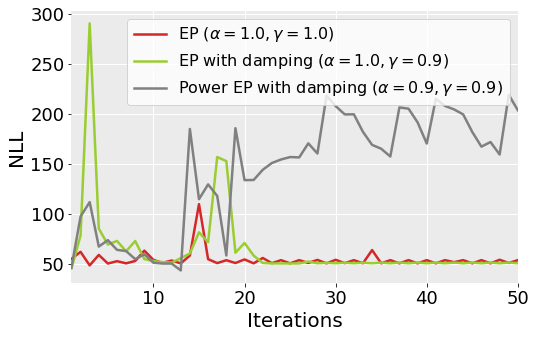

In [19]:
ax = plot_power_ep_comparison(cursor, power_list, damping_list, seed=seed, table_name=exp_table, trans_id=trans, metric='nll')
plt.legend(loc='upper right', fontsize=16)
ax.set_xlabel("Iterations", fontsize=20)
ax.set_ylabel("NLL", fontsize=20)
plt.savefig(f"figs/Power_EP_comparison_{trans}_{seed}_NLL.pdf", bbox_inches='tight')

In [9]:
@dataclass
class PlotConfig:
    figsize: Tuple = (12, 5)
    xlabel_fontsize: int = 16
    ylabel_fontsize: int = 16
    title_fontsize: int = 16
    legend_fontsize: int = 12
    xticks: Iterable = None
    xtick_labels: Iterable = None
    xtick_labelsize: int = 16
    yticks: Iterable = None
    ytick_labels: Iterable = None
    ytick_labelsize: int = 16
    cbar_ticks: Iterable = None
    cbar_tick_labels: Iterable = None
    vmin_rmse: float = None
    vmax_rmse: float = None
    vmin_nll: float = None
    vmax_nll: float = None
    xmin: float = None
    xmax: float = None


@dataclass
class ExpConfig:
    Seeds: Iterable
    exp_tablename : str
    cursor: sqlite3.Cursor


def _split_variables(control_vars):
    """ Split variables (Power, Damping, Iter) into a control set (fixed during plot) and a dependent set
    """
    control_varnames = list(control_vars.keys())
    control_vardata = []
    for key in control_varnames:
        control_vardata.append(control_vars[key])
    
    vars = ['Power', 'Damping', 'Iter']
    for key in control_varnames:
        assert key in vars, 'Control variable must be one of (Power, Damping, Iter)'

    query_str = "SELECT {} FROM {} WHERE Transform='{}' AND Seed={}"
    for var in control_varnames:
        query_str = query_str + f" AND {var}"
        if var == 'Transform':
            query_str = query_str + "='{}'"
        else:
             query_str = query_str + "={}"
        vars.remove(var)

    dependent_varnames = vars

    return control_varnames, dependent_varnames, control_vardata, query_str
    

def plot_experiment(
        control_vars: Dict, metric: str,
        plot_config: PlotConfig, exp_config: ExpConfig, ax=None,
        trans_types=['TT', 'UT', 'MCT'], colors=['C3', 'C2', 'C0'],
        power_display_name='Power', damping_display_name='Damping', iter_display_name='Iteration',
        title=True, xlabel=True, ylabel=True, legend=True, figsize=None
        ):
    assert metric in ['rmse', 'nll'], 'metric must be one of (rsme, nll)'
    assert len(trans_types) == len(colors), 'Number of transformation types and colors must match'

    # Get data and variable names (e.g. Power and Damping)
    control_varnames, dependent_varname, control_vardata, query_str = _split_variables(control_vars)
    assert len(control_varnames) == 2, 'Must specify two control variables'
    data1, data2 = control_vardata[0][0], control_vardata[1][0]
    key1, key2 = control_varnames
    key3 = dependent_varname[0]
    labels = {'Power': power_display_name, 'Damping': damping_display_name, 'Iter': iter_display_name}

    Seeds, exp_table, cursor = exp_config.Seeds, exp_config.exp_tablename, exp_config.cursor
    if Seeds is None:
        Seeds = cursor.fetchall()
        Seeds = [seed[0] for seed in Seeds]

    # Create figure
    if ax is None:
        figsize_ = figsize if figsize is not None else plot_config.figsize # Override figsize when specified explicitly
        fig = plt.figure(figsize=figsize_)
        ax = plt.gca()
    ax.set_facecolor('#EBEBEB')
    ax.grid(True, color='w', linestyle='-', linewidth=1)
    ax.set_axisbelow(True)
    plt.rcParams['xtick.labelsize'] = plot_config.xtick_labelsize
    plt.rcParams['ytick.labelsize'] = plot_config.ytick_labelsize

    for c, trans_id in zip(colors, trans_types):
        data = []
        for SEED in Seeds:
            row = cursor.execute(query_str.format(metric, exp_table, trans_id, int(SEED), data1, data2)).fetchall()
            data.append(np.array(row).squeeze()[:50])
        data = np.array(data)

        ax = plot_1d_data(data, label=trans_id, c=c, ax=ax, linewidth=2.5)
    
    # Set title, labels and legend
    if title:
        ax.set_title(f"{labels[key1]}: {data1}, {labels[key2]}: {data2}", fontsize=plot_config.title_fontsize)
    if ylabel:
        if metric == 'rmse':
            ax.set_ylabel("RMSE", fontsize=plot_config.ylabel_fontsize)
        elif metric == 'nll':
            ax.set_ylabel("NLL", fontsize=plot_config.ylabel_fontsize)
    if xlabel:
        ax.set_xlabel(f"{labels[key3]}", fontsize=plot_config.xlabel_fontsize)
    if legend:
        ax.legend(fontsize=plot_config.legend_fontsize, loc='upper right', ncol=3)

    # Format axes (ticks, ticklabels, limits)
    xticks, yticks = plot_config.xticks, plot_config.yticks
    xticklabels, yticklabels = plot_config.xtick_labels, plot_config.ytick_labels
    if xticks is not None: ax.set_xticks(xticks)
    if xticklabels is not None: ax.set_xticklabels(xticklabels)
    if yticks is not None: ax.set_yticks(yticks)
    if yticklabels is not None: ax.set_yticklabels(yticklabels)

    if metric == 'rmse':
        vmin, vmax = plot_config.vmin_rmse, plot_config.vmax_rmse
    elif metric == 'nll':
        vmin, vmax = plot_config.vmin_nll, plot_config.vmax_nll

    ax.set_ylim(vmin, vmax)
    if plot_config.xmin is not None and plot_config.xmax is not None:
        xmin, xmax = plot_config.xmin, plot_config.xmax
        ax.set_xlim(xmin, xmax)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(-3,3))

    # Remove borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.tight_layout()

    return ax


def plot_multiple_experiments(
        control_vars: Dict, plot_config: PlotConfig, exp_config: ExpConfig,
        trans_types=['TT', 'UT', 'MCT'], colors=['C3', 'C2', 'C0'],
        power_display_name='Power', damping_display_name='Damping', iter_display_name='Iteration',
        ):
    assert len(trans_types) == len(colors), 'Number of transformation types and colors must match'
    control_varnames, dependent_varname, control_vardata, query_str = _split_variables(control_vars)
    assert len(control_varnames) == 2, 'Must specify two control variables'
    data1, data2 = control_vardata
    key1, key2 = control_varnames

    # Plot results
    ncol = len(data1)
    fig, axs = plt.subplots(2, ncol, figsize=plot_config.figsize)
    for i, params in enumerate(zip(data1, data2)):
        param1, param2 = params
        data = {key1: [param1], key2: [param2]}
        kwargs = {'trans_types': trans_types,
                  'colors': colors,
                  'power_display_name': power_display_name,
                  'damping_display_name': damping_display_name,
                  'iter_display_name': iter_display_name,
                  'title': True, 'xlabel': False,
                  'ylabel': False, 'legend': True}
        if i == 0:
            kwargs['ylabel'] = True
        
        rmse_ax = axs[0] if ncol==1 else axs[0,i]
        nll_ax = axs[1] if ncol==1 else axs[1,i]
        plot_experiment(data, 'rmse', plot_config, exp_config, ax=rmse_ax, **kwargs)
        kwargs['xlabel'] = True
        kwargs['title'] = False
        plot_experiment(data, 'nll', plot_config, exp_config, ax=nll_ax, **kwargs)

    plt.tight_layout()

    return fig, axs


def first_iteration_mean(exp_config, trans_type='UT'):
    rmse_list = []
    nll_list = []
    query_str = "SELECT {} FROM {} WHERE Transform='{}' AND Seed={} AND Damping=1.0 AND Power=1.0 AND Iter=1"
    for seed in exp_config.Seeds:
        row = cursor.execute(query_str.format('RMSE', exp_config.exp_tablename, trans_type, seed)).fetchall()
        rmse_list.append(row[0][0])
        row = cursor.execute(query_str.format('NLL', exp_config.exp_tablename, trans_type, seed)).fetchall()
        nll_list.append(row[0][0])
    average_rmse = np.array(rmse_list).mean()
    average_nll = np.array(nll_list).mean()
    return average_rmse, average_nll


def plot_first_iteration_results(axs, exp_config, trans_types=['TT', 'UT', 'MCT'], colors=['C3', 'C2', 'C0'], metric='rmse', linewidth=2.5):
    for i, trans_type in enumerate(trans_types):
        average_rmse, average_nll = first_iteration_mean(exp_config, trans_type)
        try: # Multiple axis case
            for j in range(3):
                axs[0, j].axhline(average_rmse, c=colors[i], ls='--', linewidth=linewidth)
                axs[1, j].axhline(average_nll, c=colors[i], ls='--', linewidth=linewidth)
        except TypeError: # Single axis case
            assert metric in ['rmse', 'nll'], 'Specified metric must be either rmse or nll'
            if metric == 'rmse':
                axs.axhline(average_rmse, c=colors[i], ls='--', linewidth=linewidth, dashes=(5, 5))
            if metric == 'nll':
                axs.axhline(average_nll, c=colors[i], ls='--', linewidth=linewidth, dashes=(5, 5))

    return axs


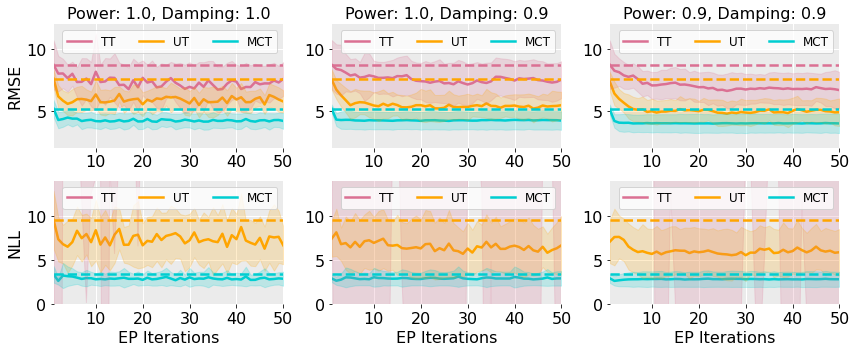

In [11]:
# Plot all experiments
experiment = 'ungm'
exp_table, cursor = select_data(experiment)
Seeds = np.arange(101, 1101, 100)
plot_config = PlotConfig(xticks=[0, 10, 20, 30, 40, 50],
                         vmin_rmse=2,
                         vmax_rmse=12,
                         vmin_nll=0,
                         vmax_nll=14,
                         xmin=1,
                         xmax=50)
exp_config = ExpConfig(Seeds=Seeds, exp_tablename=exp_table, cursor=cursor)
power_list = [1.0, 1.0, 0.9]
damping_list = [1.0, 0.9, 0.9]
control_vars = {'Power': power_list, 'Damping': damping_list}

colors = ['palevioletred', 'orange', 'darkturquoise']
# ['palevioletred', 'orange', 'darkturquoise']
# ['salmon', 'orange', 'grey']
fig, axs = plot_multiple_experiments(control_vars, plot_config, exp_config, iter_display_name='EP Iterations', colors=colors) #, trans_types=['UT', 'MCT'], colors=[colors[1], colors[2]])
axs = plot_first_iteration_results(axs, exp_config, colors=colors) #, trans_types=['UT', 'MCT'], colors=[colors[1], colors[2]])

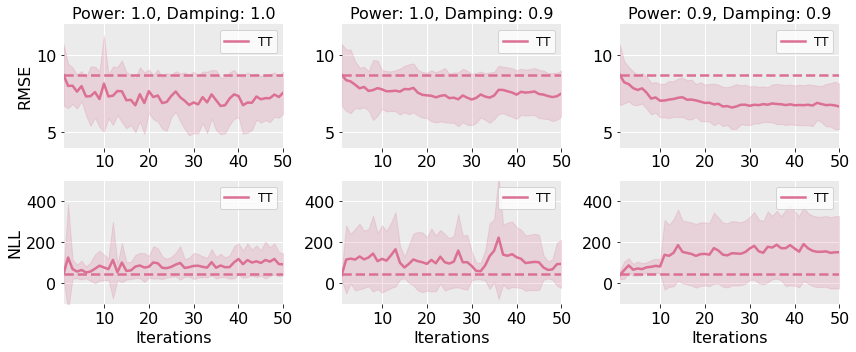

In [31]:
# Plot for Taylor transform only
plot_config = PlotConfig(xticks=[0, 10, 20, 30, 40, 50],
                         vmin_rmse=4, vmax_rmse=12,
                         vmin_nll=-100, vmax_nll=500,
                         xmin=1, xmax=50)
fig, axs = plot_multiple_experiments(control_vars, plot_config, exp_config, trans_types=['TT'], colors=[colors[0]], iter_display_name='Iterations')
axs = plot_first_iteration_results(axs, exp_config, trans_types=['TT'], colors=[colors[0]])

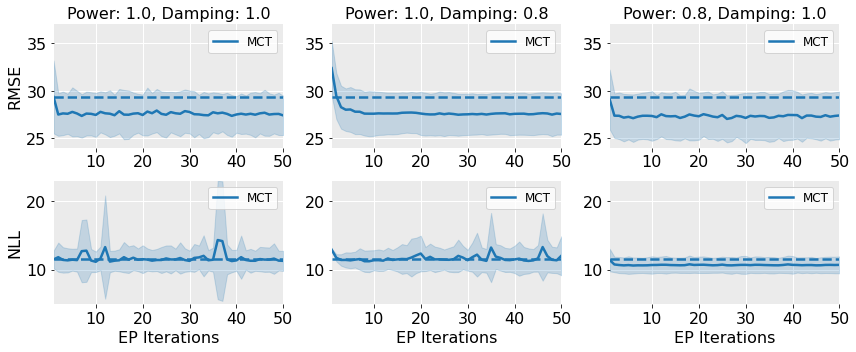

In [32]:
# Plot all experiments
experiment = 'bott'
exp_table, cursor = select_data(experiment)
Seeds = np.arange(101, 1101, 100)
plot_config = PlotConfig(xticks=[0, 10, 20, 30, 40, 50],
                         vmin_rmse=24,
                         vmax_rmse=37,
                         vmin_nll=5,
                         vmax_nll=23,
                         xmin=1,
                         xmax=50)
                         
# plot_config = PlotConfig(xticks=[0, 10, 20, 30, 40, 50],
#                          vmin_rmse=None,
#                          vmax_rmse=None,
#                          vmin_nll=None,
#                          vmax_nll=None,
#                          xmin=1,
#                          xmax=50)

exp_config = ExpConfig(Seeds=Seeds, exp_tablename=exp_table, cursor=cursor)
power_list = [1.0, 1.0, 0.8]
damping_list = [1.0, 0.8, 1.0]
control_vars = {'Power': power_list, 'Damping': damping_list}

colors = ['C0']
trans_types = ['MCT']
# ['palevioletred', 'orange', 'darkturquoise']
# ['salmon', 'orange', 'grey']
fig, axs = plot_multiple_experiments(control_vars, plot_config, exp_config, iter_display_name='EP Iterations', colors=colors, trans_types=trans_types)
axs = plot_first_iteration_results(axs, exp_config, colors=colors, trans_types=trans_types)
plt.savefig("figs/bearings_only_MCT_results.pdf")

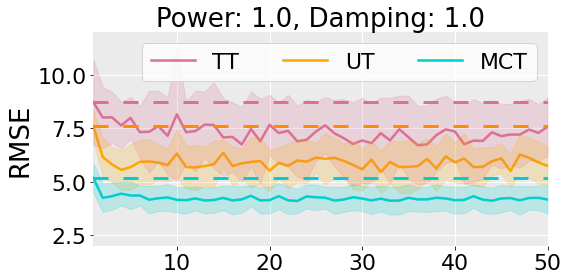

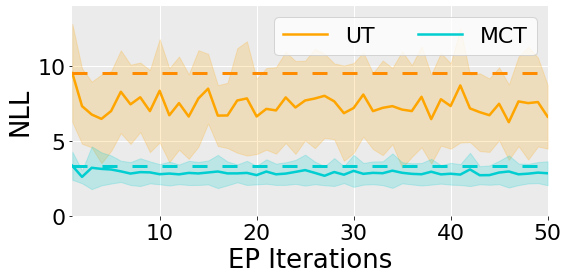

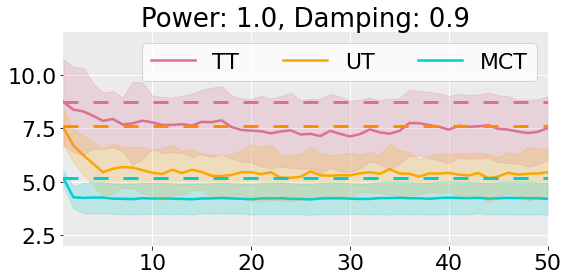

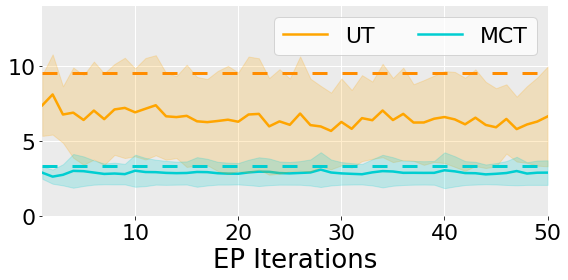

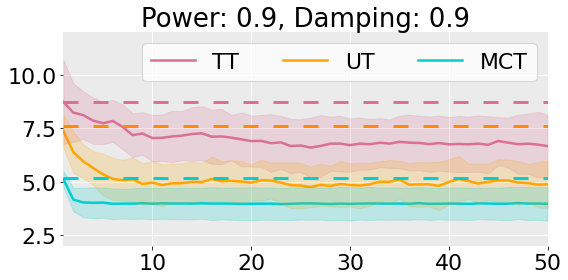

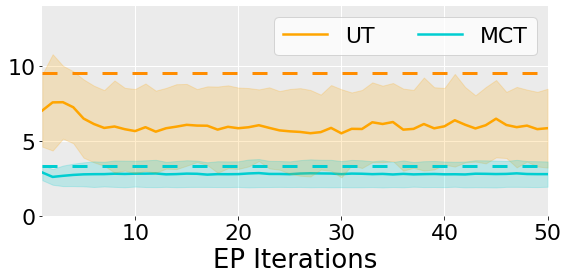

In [22]:
# Plots in paper
plot_config = PlotConfig(figsize=(8,4),
                         xticks=[0, 10, 20, 30, 40, 50],
                         vmin_rmse=2, vmax_rmse=12,
                         vmin_nll=0, vmax_nll=14,
                         xmin=1, xmax=50,
                         xlabel_fontsize=26, ylabel_fontsize=26,
                         title_fontsize=26, legend_fontsize=22,
                         xtick_labelsize=22, ytick_labelsize=22)
Seeds = np.arange(101, 1101, 100)
exp_config = ExpConfig(Seeds=Seeds, exp_tablename=exp_table, cursor=cursor)

def _permute(control_vars):
    for key, value in control_vars.items():
        new_values = []
        N = len(value)
        for i in range(1, N+1):
            new_values.append(value[i%N])
        control_vars[key] = new_values


power_list = [1.0, 1.0, 0.9]
damping_list = [1.0, 0.9, 0.9]
control_vars = {'Power': power_list, 'Damping': damping_list}

colors=['palevioletred', 'orange', 'darkturquoise']
colors2=['palevioletred', 'darkorange', 'darkturquoise']

ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, colors=colors, iter_display_name='Iterations', xlabel=False)
ax = plot_first_iteration_results(ax, exp_config, colors=colors2, metric='rmse', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_RMSE.pdf")
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, trans_types=['UT', 'MCT'], colors=colors[1:], iter_display_name='EP Iterations', title=False)
ax = plot_first_iteration_results(ax, exp_config, trans_types=['UT', 'MCT'], colors=colors2[1:], metric='nll', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_NLL.pdf")

_permute(control_vars)

ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, colors=colors, iter_display_name='Iterations', xlabel=False, ylabel=False)
ax = plot_first_iteration_results(ax, exp_config, colors=colors2, metric='rmse', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_RMSE.pdf")
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, trans_types=['UT', 'MCT'], colors=colors[1:], iter_display_name='EP Iterations', ylabel=False, title=False)
ax = plot_first_iteration_results(ax, exp_config, trans_types=['UT', 'MCT'], colors=colors2[1:], metric='nll', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_NLL.pdf")

_permute(control_vars)

ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, colors=colors, iter_display_name='Iterations', xlabel=False, ylabel=False)
ax = plot_first_iteration_results(ax, exp_config, colors=colors2, metric='rmse', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_RMSE.pdf")
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, trans_types=['UT', 'MCT'], colors=colors[1:], iter_display_name='EP Iterations', ylabel=False, title=False)
ax = plot_first_iteration_results(ax, exp_config, trans_types=['UT', 'MCT'], colors=colors2[1:], metric='nll', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_NLL.pdf")

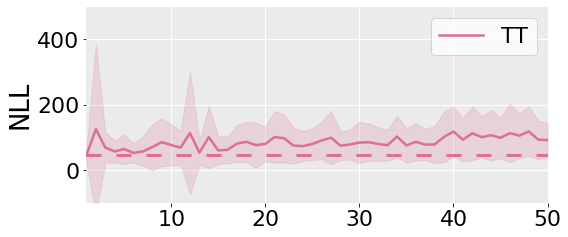

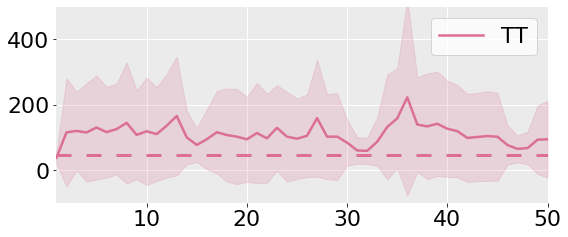

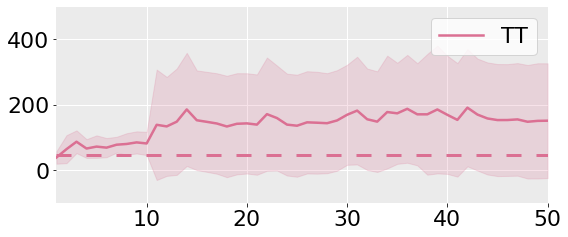

In [61]:
# Plots in paper (TT only for NLL)
power_list = [1.0, 1.0, 0.9]
damping_list = [1.0, 0.9, 0.9]
control_vars = {'Power': power_list, 'Damping': damping_list}
plot_config = PlotConfig(figsize=(8,3.4),
                         xticks=[0, 10, 20, 30, 40, 50],
                         vmin_rmse=4, vmax_rmse=12,
                         vmin_nll=-100, vmax_nll=500,
                         xmin=1, xmax=50,
                         xlabel_fontsize=26, ylabel_fontsize=26,
                         title_fontsize=26, legend_fontsize=22,
                         xtick_labelsize=22, ytick_labelsize=22)

ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, iter_display_name='EP Iterations', trans_types=['TT'], colors=[colors[0]], title=False, xlabel=False)
ax = plot_first_iteration_results(ax, exp_config, trans_types=['TT'], colors=[colors[0]], metric='nll', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_NLL_TT_only.pdf")
_permute(control_vars)
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, iter_display_name='EP Iterations', trans_types=['TT'], colors=[colors[0]], ylabel=False, title=False, xlabel=False)
ax = plot_first_iteration_results(ax, exp_config, trans_types=['TT'], colors=[colors[0]], metric='nll', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_NLL_TT_only.pdf")
_permute(control_vars)
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, iter_display_name='EP Iterations', trans_types=['TT'], colors=[colors[0]], ylabel=False, title=False, xlabel=False)
ax = plot_first_iteration_results(ax, exp_config, trans_types=['TT'], colors=[colors[0]], metric='nll', linewidth=3.0)
plt.savefig(f"figs/Experiment_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_NLL_TT_only.pdf")

(-30.0, 1000.0)

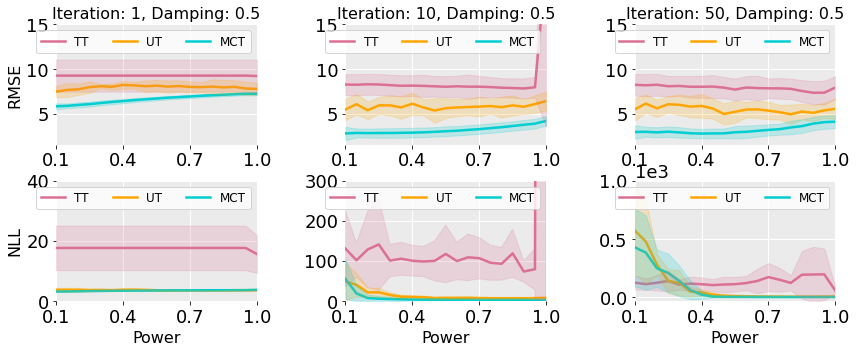

In [20]:
# Plot power sweep for fixed damping rate
experiment = 'ungm'
exp_table, cursor = select_data(experiment)
plot_config = PlotConfig(xticks=np.linspace(1, 19, 4),
                         xtick_labels=np.linspace(0.1, 1.0, 4),
                         vmin_rmse=1.5, vmax_rmse=15,
                         vmin_nll=None, vmax_nll=None,
                         xmin=1, xmax=19)
exp_config = ExpConfig(Seeds=Seeds, exp_tablename=exp_table, cursor=cursor)
iter_list = [1, 10, 50]
damping = 0.5
damping_list = [damping for _ in iter_list]
control_vars = {'Iter': iter_list, 'Damping': damping_list}
fig, axs = plot_multiple_experiments(control_vars, plot_config, exp_config, colors=colors)
axs[1, 0].set_ylim(0, 40)
axs[1, 1].set_ylim(0, 300)
axs[1, 2].set_ylim(-30, 1000)

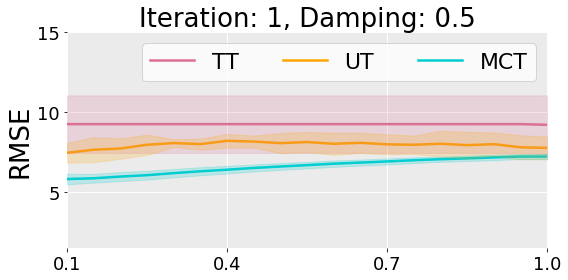

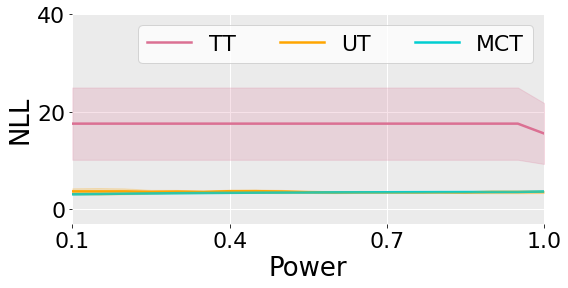

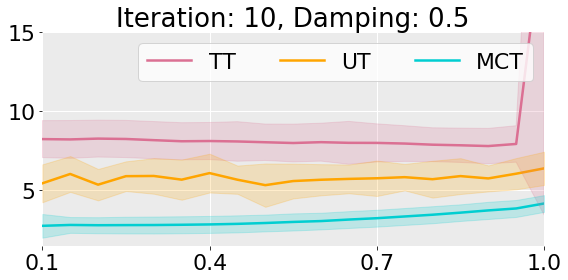

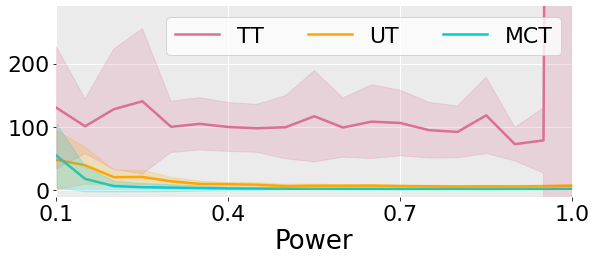

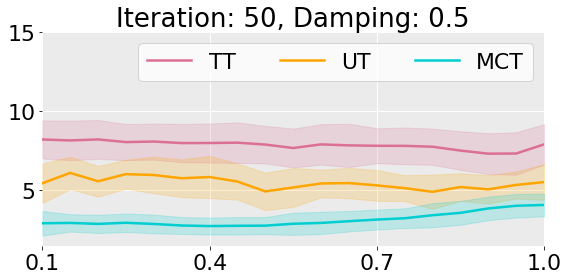

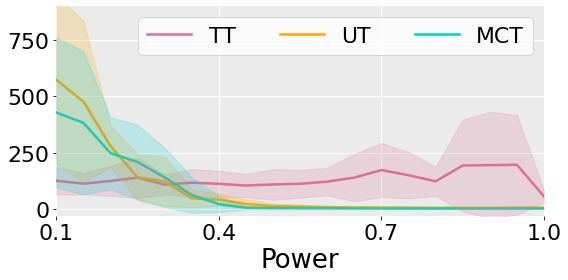

In [46]:
# Plots in paper (power sweep)
plot_config = PlotConfig(figsize=(8,4),
                         xticks=np.linspace(1, 19, 4),
                         xtick_labels=np.linspace(0.1, 1.0, 4),
                         vmin_rmse=1.5, vmax_rmse=15,
                         vmin_nll=None, vmax_nll=None,
                         xmin=1, xmax=19,
                         xlabel_fontsize=26, ylabel_fontsize=26,
                         title_fontsize=26, legend_fontsize=22,
                         xtick_labelsize=22, ytick_labelsize=22)

iter_list = [1, 10, 50]
damping = 0.5
damping_list = [damping for _ in iter_list]
control_vars = {'Iter': iter_list, 'Damping': damping_list}

ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, colors=colors, xlabel=False)
plt.savefig(f"figs/Power_sweep_iter_{control_vars['Iter'][0]}_damp_{control_vars['Damping'][0]}_RMSE.pdf")
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, colors=colors, title=False)
ax.set_ylim(-3, 40)
plt.savefig(f"figs/Power_sweep_iter_{control_vars['Iter'][0]}_damp_{control_vars['Damping'][0]}_NLL.pdf")

_permute(control_vars)

ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, colors=colors, xlabel=False, ylabel=False)
plt.savefig(f"figs/Power_sweep_iter_{control_vars['Iter'][0]}_damp_{control_vars['Damping'][0]}_RMSE.pdf")
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, colors=colors, ylabel=False, title=False, figsize=(8,4.3))
ax.set_ylim(-10, 290)
plt.savefig(f"figs/Power_sweep_iter_{control_vars['Iter'][0]}_damp_{control_vars['Damping'][0]}_NLL.pdf", bbox_inches='tight')

_permute(control_vars)

ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, colors=colors, xlabel=False, ylabel=False)
plt.savefig(f"figs/Power_sweep_iter_{control_vars['Iter'][0]}_damp_{control_vars['Damping'][0]}_RMSE.pdf")
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, colors=colors, ylabel=False, title=False)
ax.set_ylim(-30, 900)
plt.savefig(f"figs/Power_sweep_iter_{control_vars['Iter'][0]}_damp_{control_vars['Damping'][0]}_NLL.pdf")


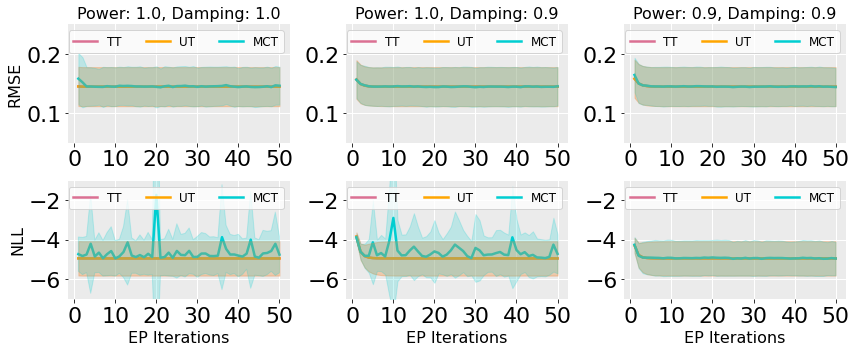

In [298]:
# Similar plots for the bearings-only tracking experiment
experiment = 'bot'
exp_table, cursor = select_data(experiment)
Seeds = np.arange(101, 1101, 100)
plot_config = PlotConfig(xticks=[0, 10, 20, 30, 40, 50], # For BOT
                         vmin_rmse=0.05,
                         vmax_rmse=0.25,
                         vmin_nll=-7,
                         vmax_nll=-1)
exp_config = ExpConfig(Seeds=Seeds, exp_tablename=exp_table, cursor=cursor)
power_list = [1.0, 1.0, 0.9]
damping_list = [1.0, 0.9, 0.9]
control_vars = {'Power': power_list, 'Damping': damping_list}

colors = ['palevioletred', 'orange', 'darkturquoise']
fig, axs = plot_multiple_experiments(control_vars, plot_config, exp_config, iter_display_name='EP Iterations', colors=colors)

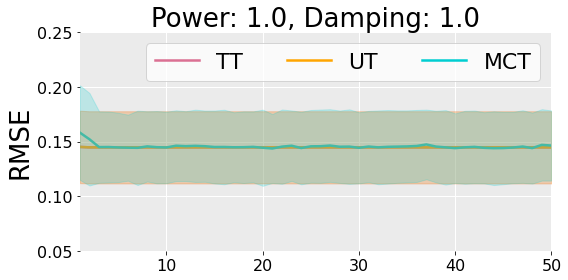

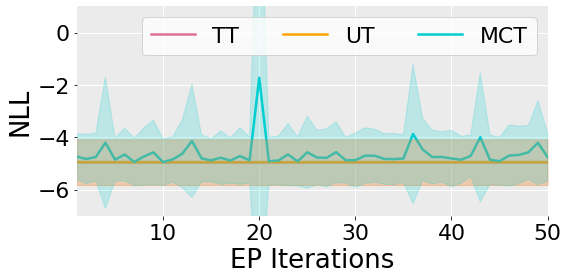

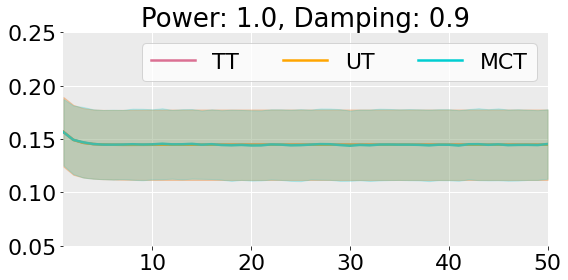

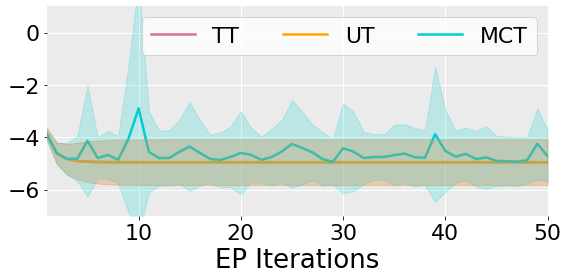

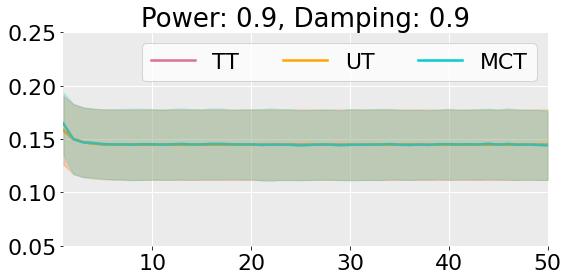

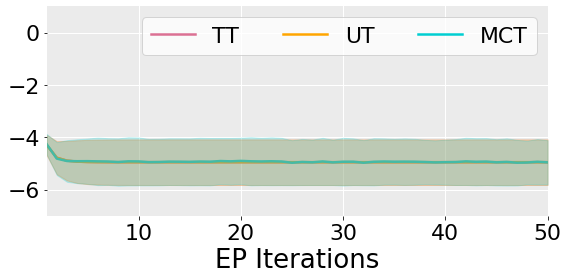

In [299]:
plot_config = PlotConfig(figsize=(8,4),
                         xticks=[0, 10, 20, 30, 40, 50],
                         vmin_rmse=0.05, vmax_rmse=0.25,
                         vmin_nll=-7, vmax_nll=1,
                         xmin=1, xmax=50,
                         xlabel_fontsize=26, ylabel_fontsize=26,
                         title_fontsize=26, legend_fontsize=22,
                         xtick_labelsize=22, ytick_labelsize=22)
Seeds = np.arange(101, 1101, 100)
exp_config = ExpConfig(Seeds=Seeds, exp_tablename=exp_table, cursor=cursor)


power_list = [1.0, 1.0, 0.9]
damping_list = [1.0, 0.9, 0.9]
control_vars = {'Power': power_list, 'Damping': damping_list}

colors=['palevioletred', 'orange', 'darkturquoise']

ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, colors=colors, iter_display_name='Iterations', xlabel=False)
plt.savefig(f"figs/Experiment_BOT_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_RMSE.pdf")
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, colors=colors, iter_display_name='EP Iterations', title=False)
plt.savefig(f"figs/Experiment_BOT_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_NLL.pdf")

_permute(control_vars)

ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, colors=colors, iter_display_name='Iterations', xlabel=False, ylabel=False)
plt.savefig(f"figs/Experiment_BOT_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_RMSE.pdf")
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, colors=colors, iter_display_name='EP Iterations', ylabel=False, title=False)
plt.savefig(f"figs/Experiment_BOT_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_NLL.pdf")

_permute(control_vars)

ax = plot_experiment(control_vars, 'rmse', plot_config, exp_config, colors=colors, iter_display_name='Iterations', xlabel=False, ylabel=False)
plt.savefig(f"figs/Experiment_BOT_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_RMSE.pdf")
ax = plot_experiment(control_vars, 'nll', plot_config, exp_config, colors=colors, iter_display_name='EP Iterations', ylabel=False, title=False)
plt.savefig(f"figs/Experiment_BOT_power_{control_vars['Power'][0]}_damp_{control_vars['Damping'][0]}_NLL.pdf")

In [34]:
# Heat map
methods = [None, 'none','nearest', 'bilinear', 'bicubic', 'spline16',
           'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric',
           'catrom', 'gaussian', 'bessel', 'mitchell', 'sinc', 'lanczos']
           

def plot_power_sweep(plot_config, img, methods, title=None, metric='rmse', ax=None):

    plt.rcParams['xtick.labelsize'] = plot_config.xtick_labelsize
    plt.rcParams['ytick.labelsize'] = plot_config.ytick_labelsize
    if ax is None:
        plt.figure(figsize=plot_config.figsize)
        ax = plt.gca()

    if metric == 'rmse':
        vmin, vmax = plot_config.vmin_rmse, plot_config.vmax_rmse
    else:
        vmin, vmax = plot_config.vmin_nll, plot_config.vmax_nll
    im = ax.imshow(img, interpolation=methods[4],
                   extent=[0.1,1,0.1,1], cmap='magma_r', #sns.cubehelix_palette(8, as_cmap=True),
                   vmax=vmax, vmin=vmin, origin='lower')

    ax.set_xlabel('Power', fontsize=plot_config.xlabel_fontsize)
    ax.set_ylabel('Damping', fontsize=plot_config.ylabel_fontsize)
    if title is not None:
        ax.set_title(title, fontsize=plot_config.title_fontsize)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    if plot_config.cbar_ticks is not None:
        cbar = plt.colorbar(im, cax=cax, ticks=plot_config.cbar_ticks)
        if plot_config.cbar_tick_labels is not None:
            cbar.ax.set_yticklabels(plot_config.cbar_tick_labels)
    else:
        plt.colorbar(im, cax=cax)
    
    plt.tight_layout()
    

def make_image_data(cursor, table, transform, seed, iters=10):
    all_iters = """
                    SELECT RMSE, NLL, Power, Damping from 
                    {}
                    WHERE Transform = '{}' AND Seed = {} AND Iter = {}
                """
    cursor.execute(all_iters.format(table, transform, seed, iters))
    data = cursor.fetchall()
    rms, nl, p, d = zip(*data)
    nl = np.array(nl)
    rms = np.array(rms)
    p = np.array(p)
    d = np.array(d)
    p = p.reshape(19, 19)
    d = d.reshape(19, 19)
    p_nll = nl.reshape(19, 19)
    p_rmse = rms.reshape(19, 19)
    
    return p_rmse, p_nll, p, d


def all_seeds_image(cursor, table, transform, iters=50, seeds=None):
  all_prmse = []
  all_pnll = []
  cursor.execute(f"SELECT DISTINCT Seed from {table}")
  if seeds is None:
    seeds = cursor.fetchall()
    seeds = [seed[0] for seed in seeds]
  for seed in seeds:
    rmse, nll, p, d = make_image_data(cursor, table, transform, seed, iters=iters)
    all_prmse.append(rmse)
    all_pnll.append(nll)
  prmse = np.array(all_prmse)
  pnll = np.array(all_pnll)

  return np.mean(prmse, axis=0), np.mean(pnll, axis=0), p, d


def plot_sweep(cursor, plot_config, table, transform, iters=10, metric='rmse', title=False, ax=None, seeds=None):
    p_rmse, p_nll, p, d = all_seeds_image(cursor, table, transform, iters=iters, seeds=seeds)
    if title == True:
        title = f'Transform = {transform}'
    else:
        title = None
    if metric == 'rmse':
        plot_power_sweep(plot_config, (p_rmse.T), methods, title, metric=metric, ax=ax)
    else:
        plot_power_sweep(plot_config, (p_nll.T), methods, title, metric=metric, ax=ax)


def plot_all_transforms(cursor, plot_config, table, iters=10, metric='rmse'):
    transform_list = ['TT', 'UT', 'MCT']
    fig, axs = plt.subplots(1, 3, figsize=plot_config.figsize) #figsize=(26, 9)
    for i, trans in enumerate(transform_list):
        plot_sweep(cursor, plot_config, table, trans, iters=iters, metric=metric, title=True, ax=axs[i])
    if metric == 'rmse':
        plt.suptitle('RMSE', fontweight='bold', fontsize=30)
    else:
        plt.suptitle('NLL', fontweight='bold', fontsize=30)
    plt.tight_layout()

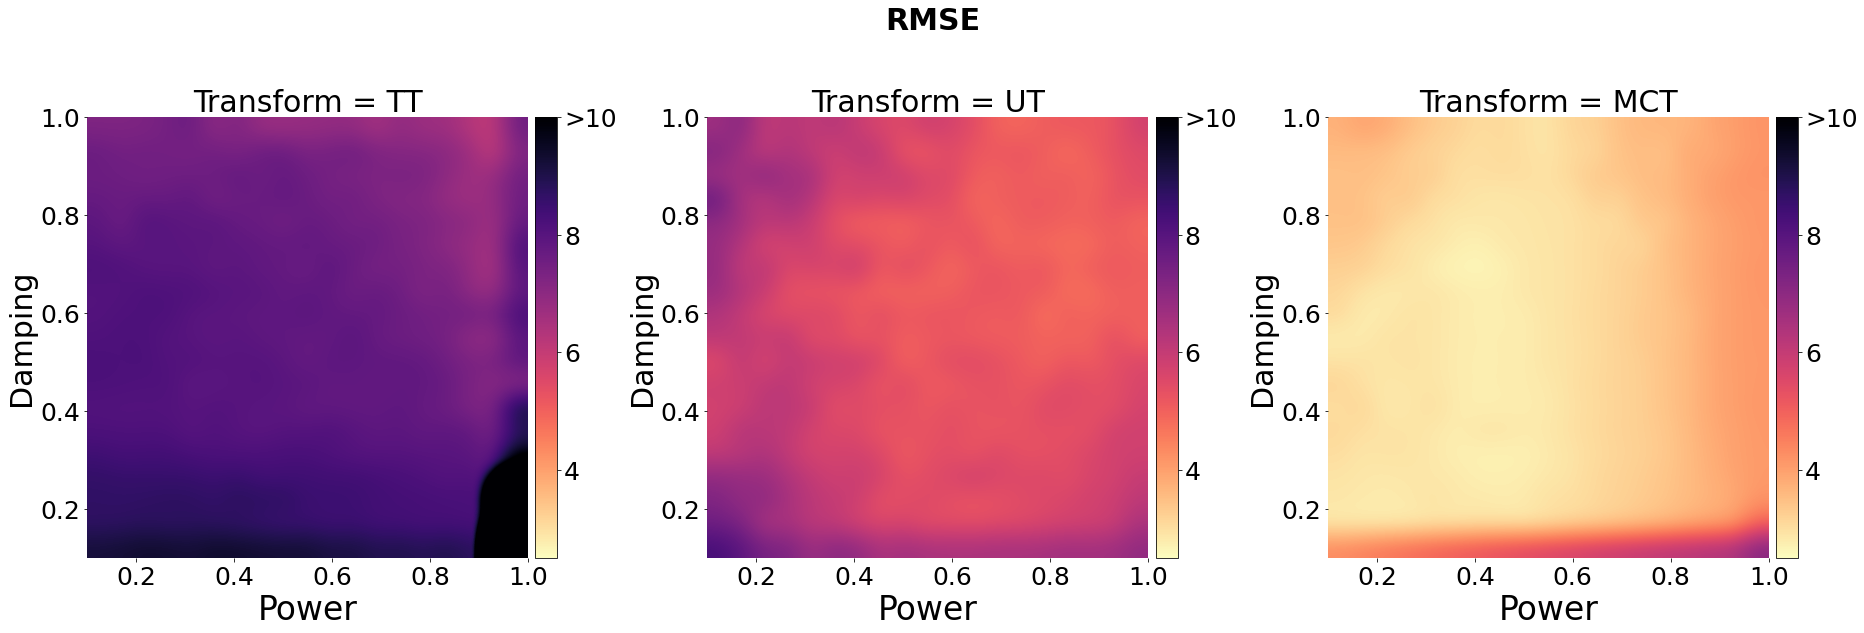

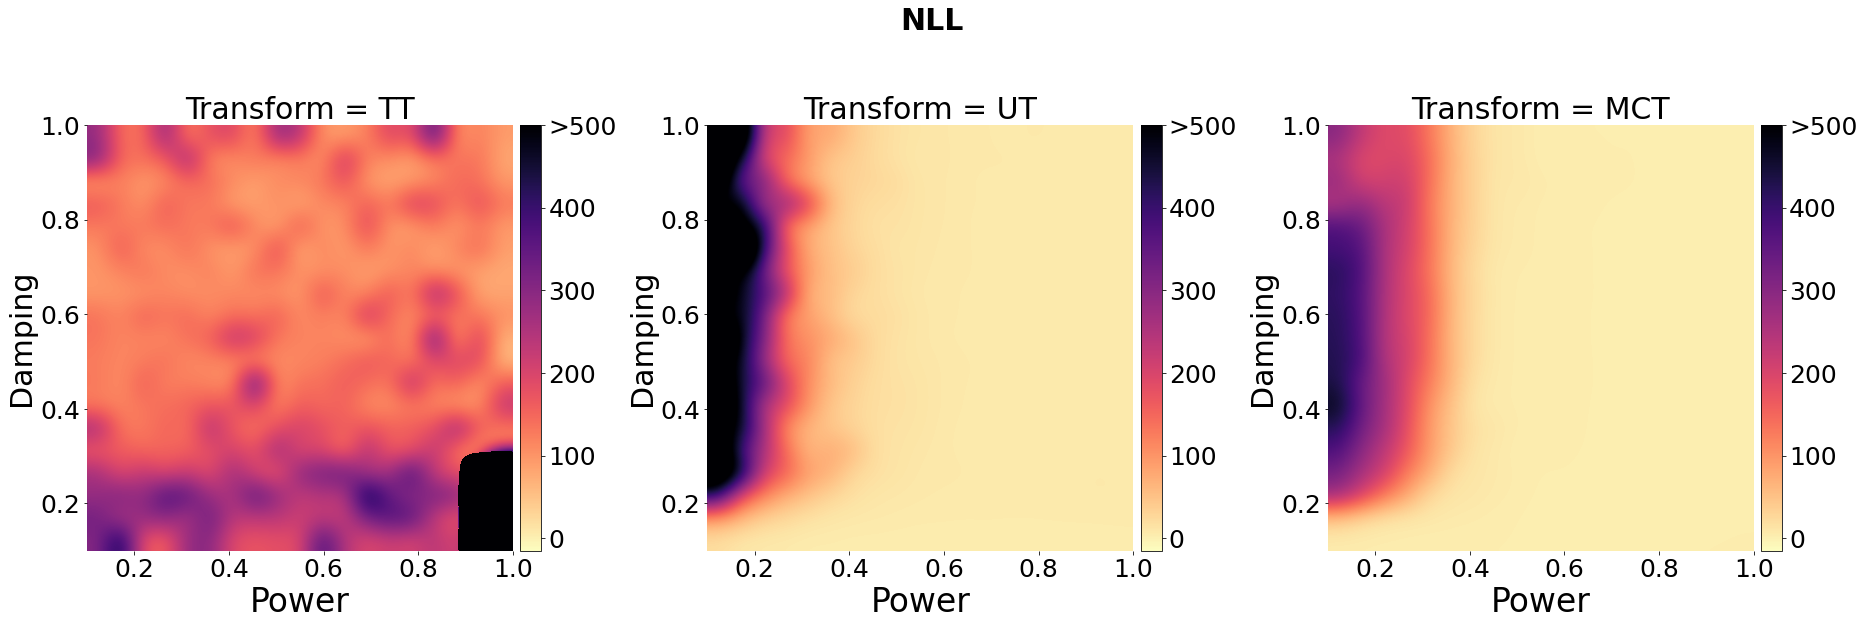

In [187]:
experiment = 'ungm'
exp_table, cursor = select_data(experiment)
plot_config = PlotConfig(figsize=(26,9),
                         vmin_rmse=2.5, vmax_rmse=10.0,
                         vmin_nll=-15.0, vmax_nll=500.0,
                         xlabel_fontsize=33, ylabel_fontsize=30,
                         title_fontsize=30,
                         xtick_labelsize=25, ytick_labelsize=25)
                         
iter = 50

cbar_ticks = np.linspace(0, 10, 6)
cbar_tickslabel = [f'{int(tick)}' for tick in cbar_ticks]
cbar_tickslabel[-1] = f'>{cbar_tickslabel[-1]}'
plot_config.cbar_ticks=cbar_ticks
plot_config.cbar_tick_labels=cbar_tickslabel
plot_all_transforms(cursor, plot_config, exp_table, iter, 'rmse')

cbar_ticks = np.linspace(0, 500, 6)
cbar_tickslabel = [f'{int(tick)}' for tick in cbar_ticks]
cbar_tickslabel[-1] = f'>{cbar_tickslabel[-1]}'
plot_config.cbar_ticks=cbar_ticks
plot_config.cbar_tick_labels=cbar_tickslabel
plot_all_transforms(cursor, plot_config, exp_table, iter, 'nll')


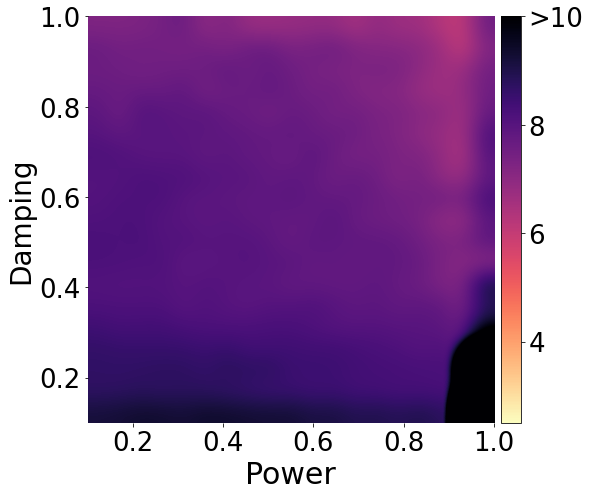

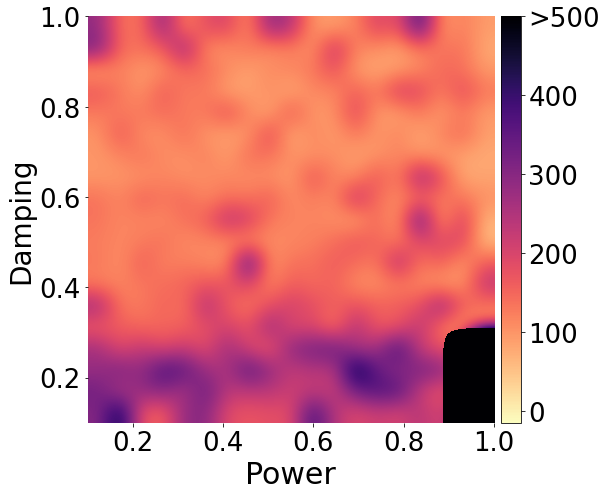

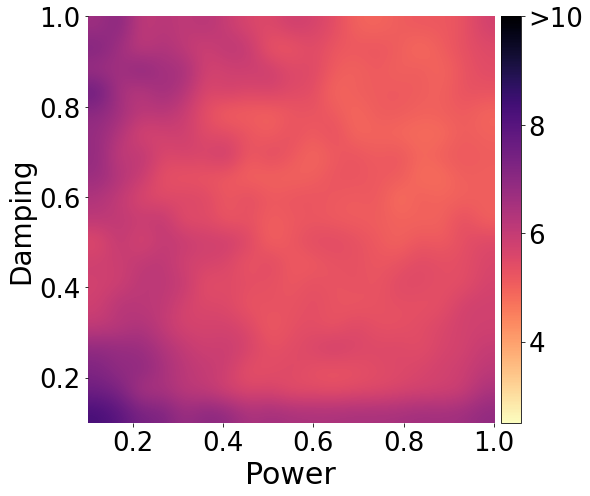

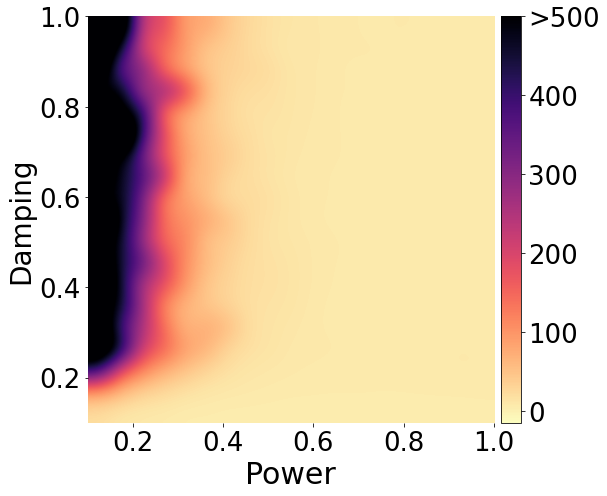

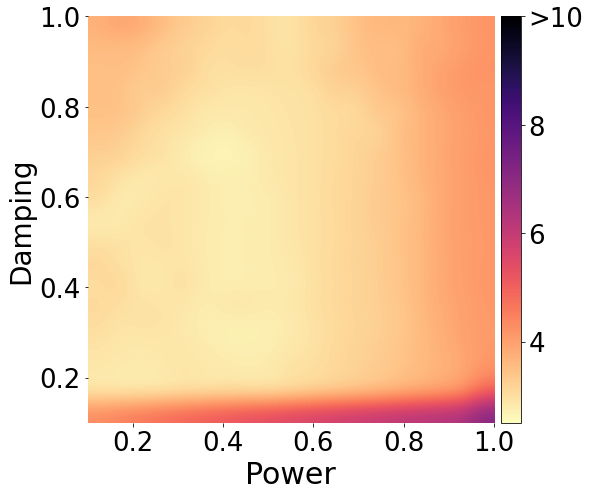

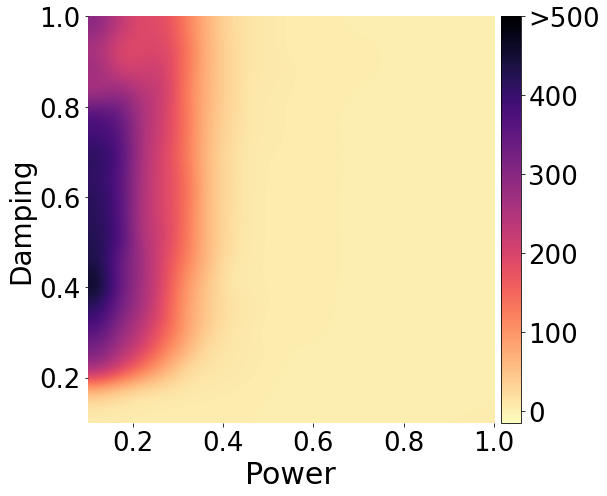

In [182]:
experiment = 'ungm'
exp_table, cursor = select_data(experiment)
plot_config = PlotConfig(figsize=(9,7),
                         vmin_rmse=2.5, vmax_rmse=10.0,
                         vmin_nll=-15.0, vmax_nll=500,
                         xlabel_fontsize=30, ylabel_fontsize=28,
                         title_fontsize=28,
                         xtick_labelsize=26, ytick_labelsize=26)

trans_types = ['TT', 'UT', 'MCT']
iter = 50
for trans in trans_types:
    cbar_ticks = np.linspace(0, 10, 6)
    cbar_tickslabel = [f'{int(tick)}' for tick in cbar_ticks]
    plot_config.cbar_ticks=cbar_ticks
    plot_config.cbar_tick_labels=cbar_tickslabel
    cbar_tickslabel[-1] = f'>{cbar_tickslabel[-1]}'
    plot_sweep(cursor, plot_config, exp_table, trans, iters=iter, metric='rmse')
    plt.savefig(f"figs/Heatmap_{experiment}_trans_{trans}_iter_{iter}_RMSE.pdf")

    cbar_ticks = np.linspace(0, 500, 6)
    cbar_tickslabel = [f'{int(tick)}' for tick in cbar_ticks]
    plot_config.cbar_ticks=cbar_ticks
    plot_config.cbar_tick_labels=cbar_tickslabel
    cbar_tickslabel[-1] = f'>{cbar_tickslabel[-1]}'
    plot_sweep(cursor, plot_config, exp_table, trans, iters=iter, metric='nll')
    plt.savefig(f"figs/Heatmap_{experiment}_trans_{trans}_iter_{iter}_NLL.pdf")

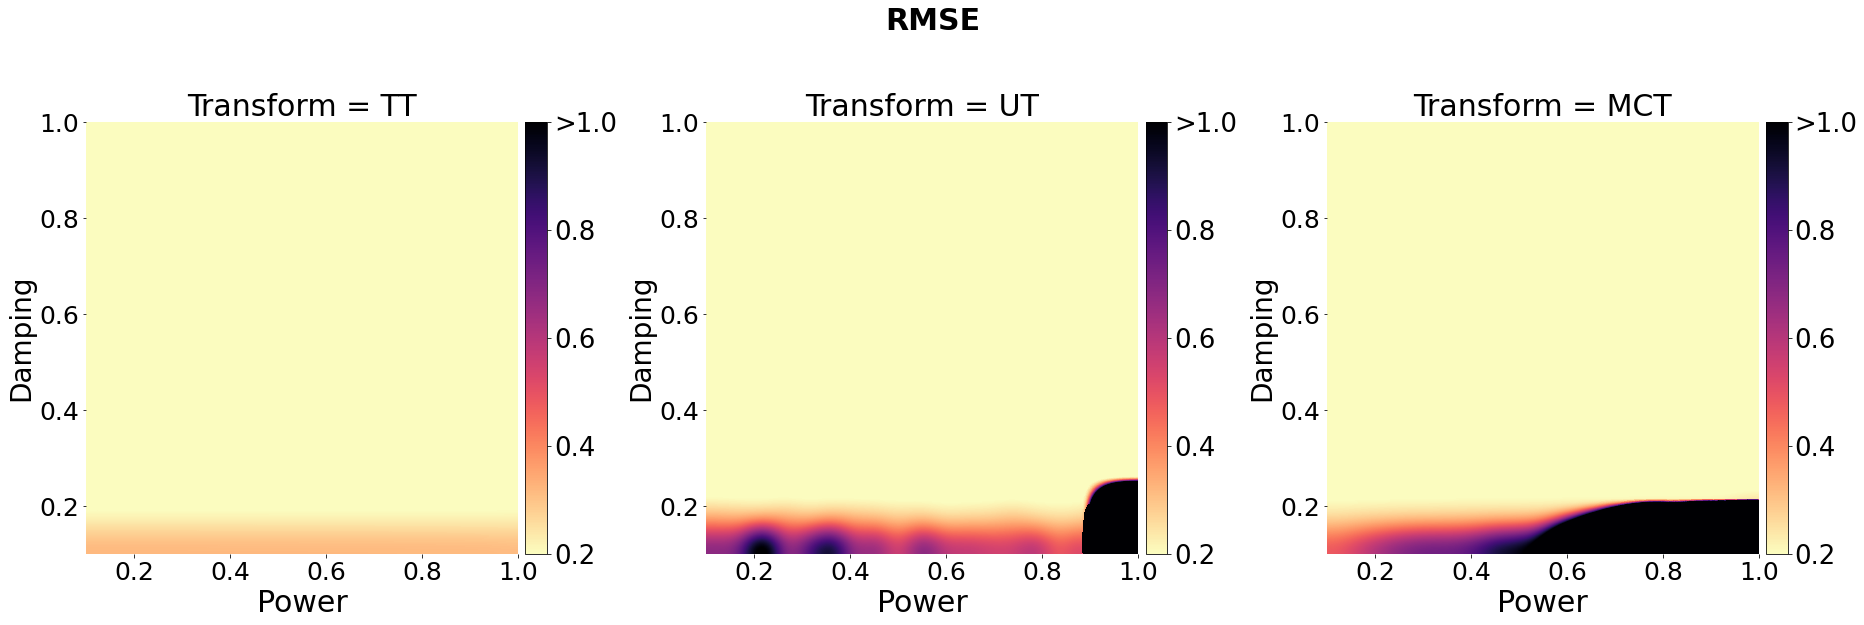

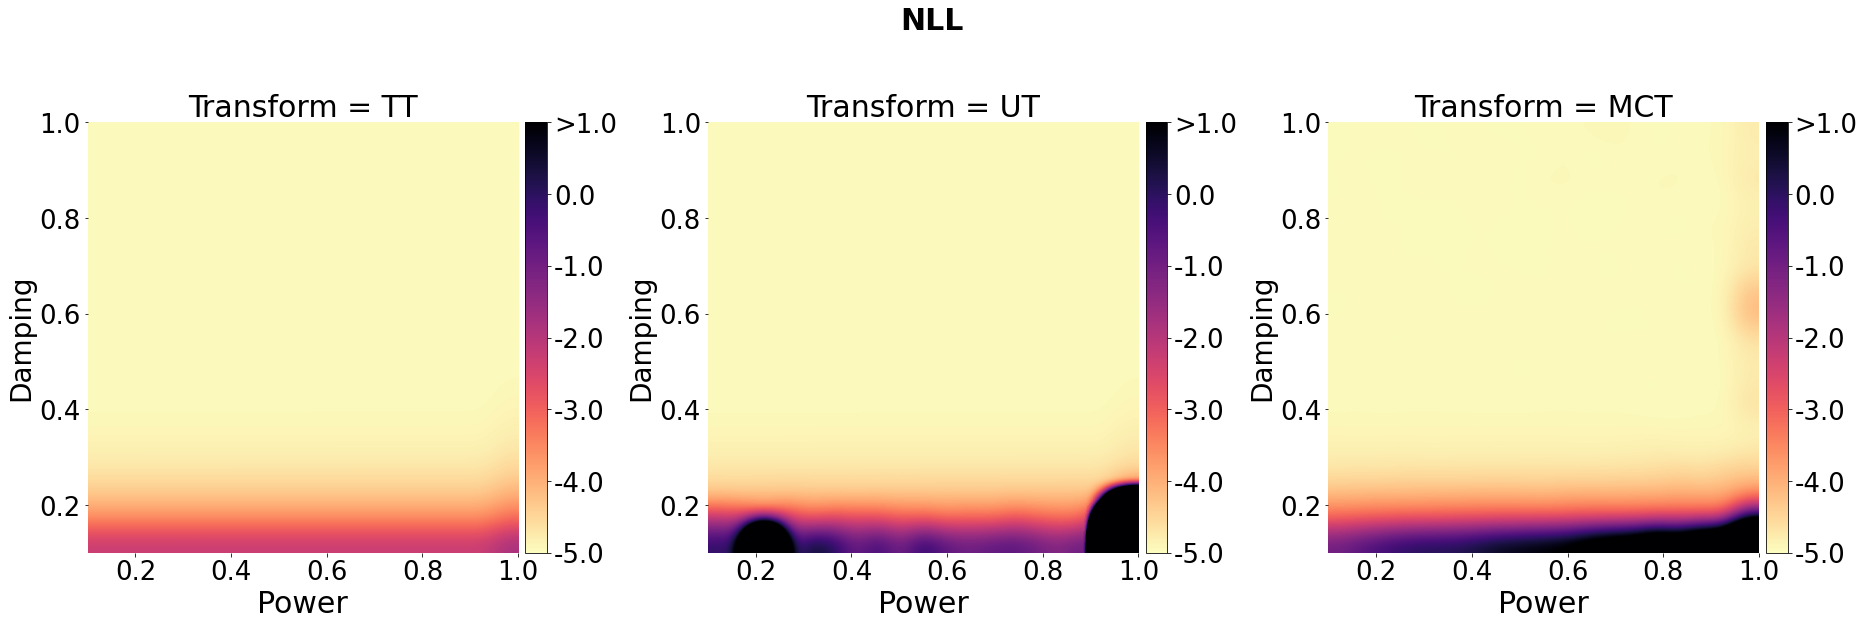

In [177]:
# Bearings only experiment
experiment = 'bot'
exp_table, cursor = select_data(experiment)
plot_config = PlotConfig(figsize=(26,9),
                         vmin_rmse=0.2, vmax_rmse=1.0,
                         vmin_nll=-5.0, vmax_nll=1.0,
                         xlabel_fontsize=30, ylabel_fontsize=28,
                         title_fontsize=30,
                         xtick_labelsize=26, ytick_labelsize=26)
iter = 50

cbar_ticks = np.linspace(0, 1, 6)
plot_config.cbar_ticks=cbar_ticks
cbar_tickslabel=[f'{tick:.1f}' for tick in cbar_ticks]
cbar_tickslabel[-1] = f'>{cbar_tickslabel[-1]}'
plot_config.cbar_tick_labels = cbar_tickslabel
plot_all_transforms(cursor, plot_config, exp_table, iter, 'rmse')

cbar_ticks = np.linspace(-5, 1, 7)
plot_config.cbar_ticks=cbar_ticks
cbar_tickslabel=[f'{tick:.1f}' for tick in cbar_ticks]
cbar_tickslabel[-1] = f'>{cbar_tickslabel[-1]}'
plot_config.cbar_tick_labels = cbar_tickslabel
plot_all_transforms(cursor, plot_config, exp_table, iter, 'nll')

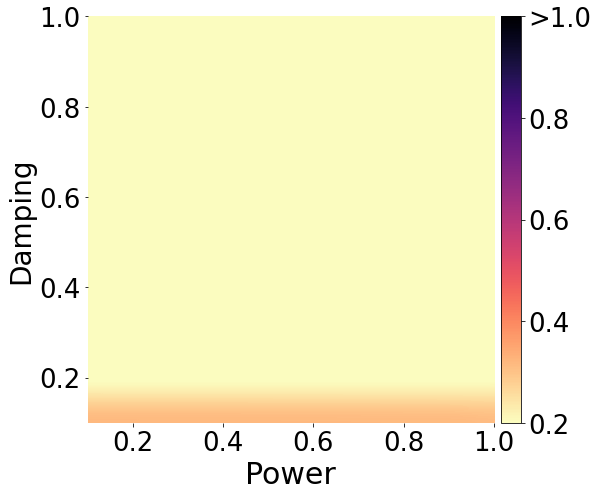

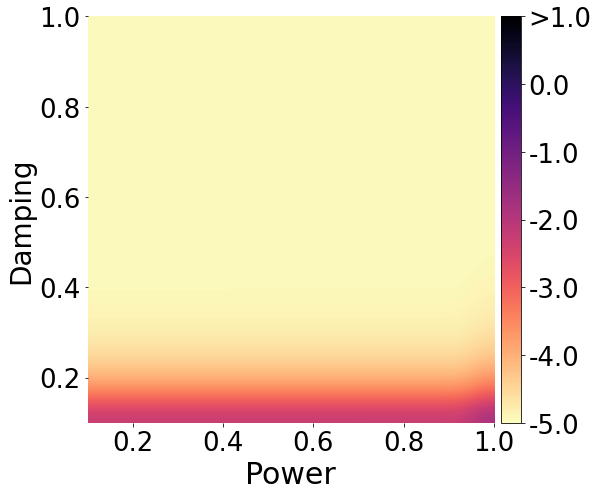

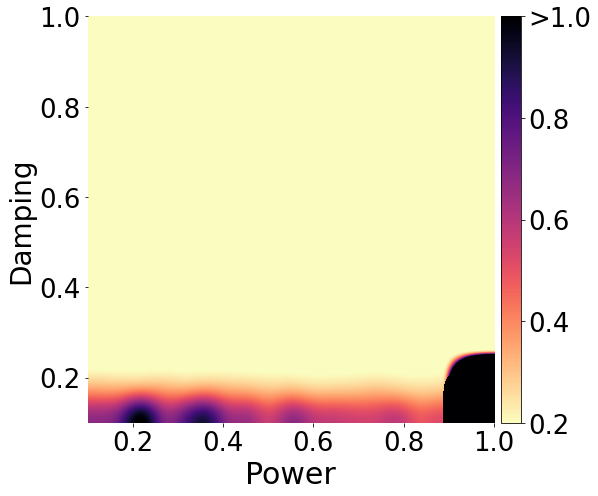

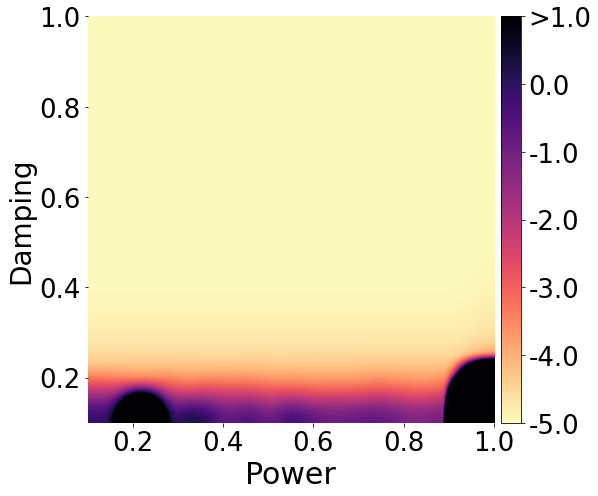

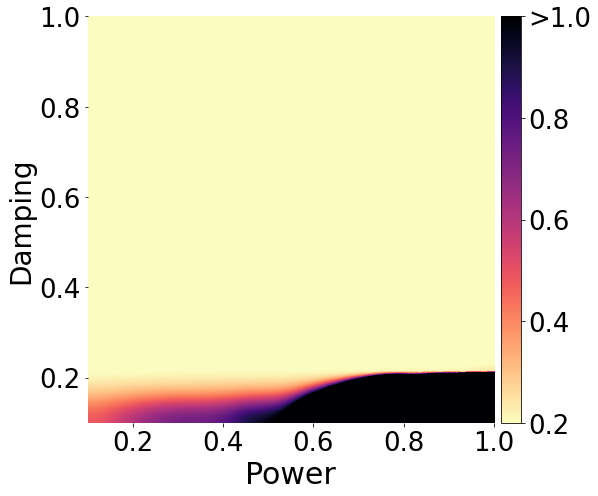

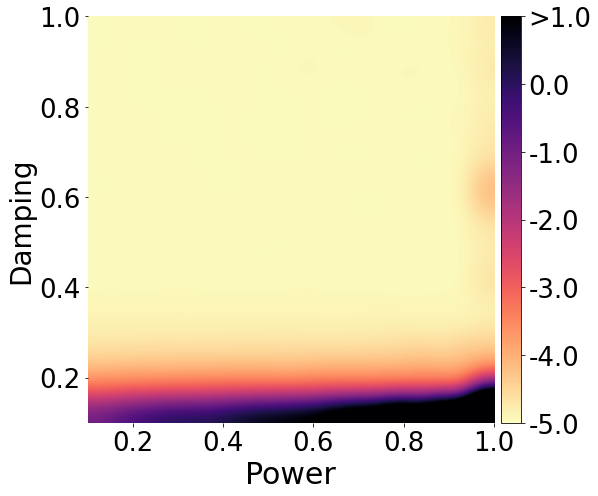

In [188]:
experiment = 'bot'
exp_table, cursor = select_data(experiment)
plot_config = PlotConfig(figsize=(9,7),
                         vmin_rmse=0.2, vmax_rmse=1.0,
                         vmin_nll=-5.0, vmax_nll=1.0,
                         xlabel_fontsize=30, ylabel_fontsize=28,
                         title_fontsize=26,
                         xtick_labelsize=26, ytick_labelsize=26)

trans_types = ['TT', 'UT', 'MCT']
iter = 50
for trans in trans_types:
    cbar_ticks = np.linspace(0, 1, 6)
    plot_config.cbar_ticks=cbar_ticks
    cbar_tickslabel=[f'{tick:.1f}' for tick in cbar_ticks]
    cbar_tickslabel[-1] = f'>{cbar_tickslabel[-1]}'
    plot_config.cbar_tick_labels = cbar_tickslabel
    plot_sweep(cursor, plot_config, exp_table, trans, iters=iter, metric='rmse')
    plt.savefig(f"figs/Heatmap_{experiment}_trans_{trans}_iter_{iter}_RMSE.pdf")

    cbar_ticks = np.linspace(-5, 1, 7)
    plot_config.cbar_ticks=cbar_ticks
    cbar_tickslabel=[f'{tick:.1f}' for tick in cbar_ticks]
    cbar_tickslabel[-1] = f'>{cbar_tickslabel[-1]}'
    plot_config.cbar_tick_labels = cbar_tickslabel
    plot_sweep(cursor, plot_config, exp_table, trans, iters=iter, metric='nll')
    plt.savefig(f"figs/Heatmap_{experiment}_trans_{trans}_iter_{iter}_NLL.pdf")

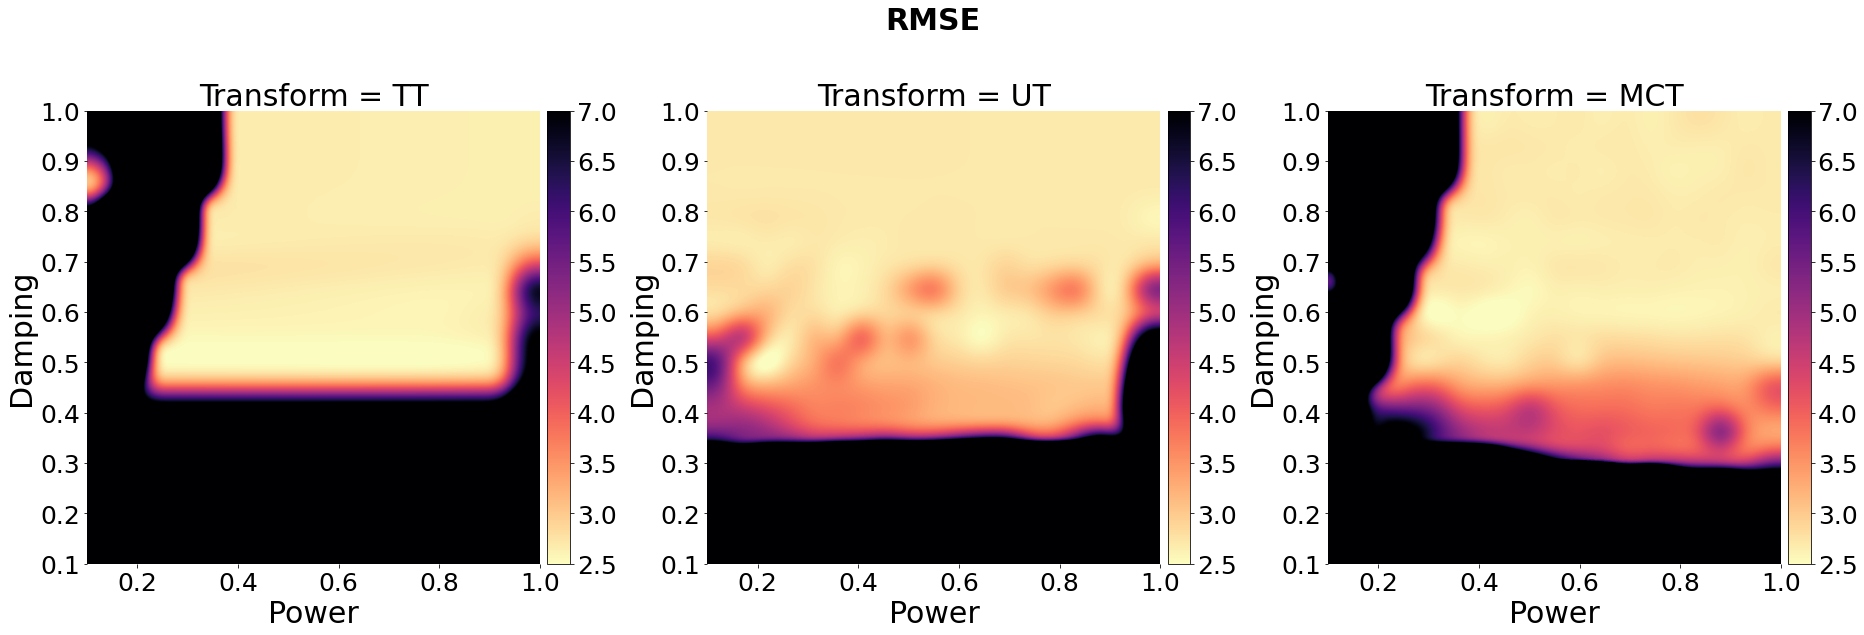

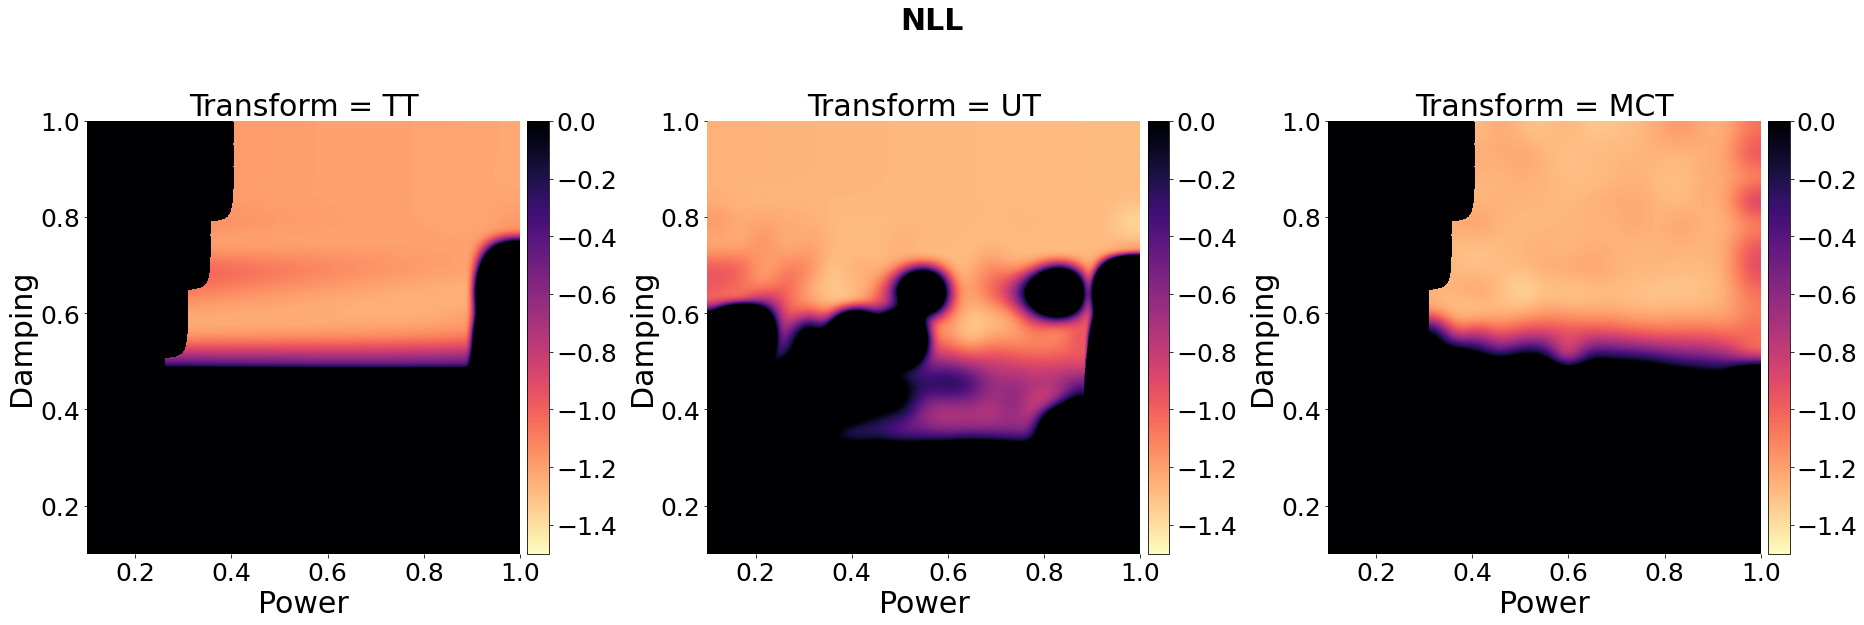

In [44]:
# Bearings only experiment
experiment = 'bott'
exp_table, cursor = select_data(experiment)
plot_config = PlotConfig(figsize=(26,9),
                         vmin_rmse=2.5, vmax_rmse=7,
                         vmin_nll=-1.5, vmax_nll=0,
                         xlabel_fontsize=30, ylabel_fontsize=30,
                         title_fontsize=30,
                         xtick_labelsize=25, ytick_labelsize=25)
iter = 50

plot_all_transforms(cursor, plot_config, exp_table, iter, 'rmse')

plot_all_transforms(cursor, plot_config, exp_table, iter, 'nll')

In [15]:
from copy import deepcopy

SEED = 801
np.random.seed(seed=SEED)
data = system.simulate(timesteps)
x_true, x_noisy, y_true, y_noisy = zip(*data)

# Build EP nodes
num_samples = int(1e4)
trans_id = 'UT'
power = 0.1
damping = 0.4
transform, meas_transform = select_transform(trans_id, dim=sys_dim, samples=num_samples)
estim = Estimator(trans_map=transform,
                meas_map=meas_transform,
                trans_noise=system.transition_noise.cov,
                meas_noise=system.measurement_noise.cov,
                power=power,
                damping=damping)

nodes = build_nodes(N=timesteps, dim=sys_dim)
nodes = node_estimator(nodes=nodes, estimator=estim)
nodes = node_system(nodes=nodes, system_model=system, measurements=y_noisy)


# Run EP iteration
max_iter = 50
iters = [0, 9, 49]
nodes_to_plot = []
rmse_list, nll_list = [], []
for i in range(max_iter):
    for node in nodes:
        node.fwd_update()
        node.meas_update()
    for node in reversed(nodes):
        node.back_update()
    if i in iters:
        nodes_to_plot.append(deepcopy(nodes))
        rmse_, nll_ = node_metrics(nodes, x_noisy)
        rmse_list.append(rmse_)
        nll_list.append(nll_)

In [16]:
def plot_smoother_results(nodes_list, iter_list, rmse_list, nll_list, ground_truth, vmin=None, vmax=None, colors=['C0', 'C2'], figsize=None):
    fig, axs = plt.subplots(len(nodes_list), figsize=figsize)
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    for i, params in enumerate(zip(nodes_list, iter_list, rmse_list, nll_list)):
        nodes, iter, rmse, nll = params
        ax = plot_gaussian_node(nodes, ground_truth, ax=axs[i], colors=colors)
        ax.set_title(f"(Iteration {iter+1}) RMSE={rmse:.2f}, NLL={nll:.2f}", fontsize=16)
        if i == len(nodes_list)-1:
            ax.set_xlabel("Time steps", fontsize=16)
        ax.set_ylim(vmin, vmax)
        ax.set_xlim(1, timesteps)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        if i == 0:
            ax.legend(loc='upper right', bbox_to_anchor=(1.04, 1.0), ncol=2, fontsize=12)
    plt.tight_layout()

    return ax


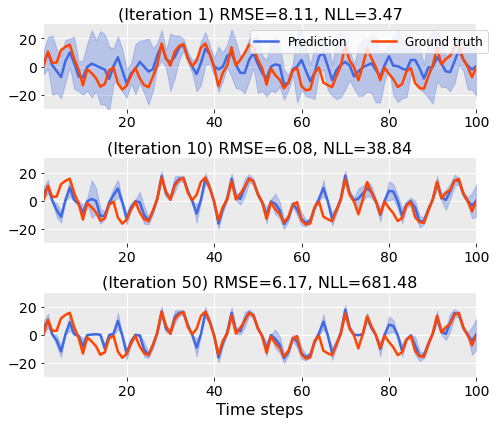

In [17]:
ax = plot_smoother_results(nodes_to_plot, iters, rmse_list, nll_list, x_noisy, figsize=(7,6), vmin=-30, vmax=30, colors=['royalblue', 'orangered'])
# ax.legend(loc='upper right', bbox_to_anchor=(1.02, 1.1), ncol=2)
plt.savefig(f"figs/Smoother_results_power_{power}_damp_{damping}.pdf")

In [30]:
SEED = 801
np.random.seed(seed=seed)
system = BearingsOnlyTracking()
timesteps = 50
sys_dim = 4

data = system.simulate(timesteps)
x_true, x_noisy, y_true, y_noisy = zip(*data)

# Build EP nodes
num_samples = int(1e4)
trans_id = 'UT'
power = 1.0
damping = 0.1
transform, meas_transform = select_transform(trans_id, dim=sys_dim, samples=num_samples)
estim = Estimator(trans_map=transform,
                meas_map=meas_transform,
                trans_noise=system.transition_noise.cov,
                meas_noise=system.measurement_noise.cov,
                power=power,
                damping=damping)

nodes = build_nodes(N=timesteps, dim=sys_dim)
nodes = node_estimator(nodes=nodes, estimator=estim)
nodes = node_system(nodes=nodes, system_model=system, measurements=y_noisy)

In [45]:
# Run EP iteration
data_saved = True
if data_saved:
    nll_list = np.load(f"NLL_{max_iter}_iterations.npy")
    rmse_list = np.load(f"RMSE_{max_iter}_iterations.npy")
else:
    max_iter = 500
    rmse_list, nll_list = [], []
    for i in range(max_iter):
        if i%10 == 0:
            print(f"Completed {i} iterations. RMSE={rmse_}, NLL={nll_}")
        for node in nodes:
            node.fwd_update()
            node.meas_update()
        for node in reversed(nodes):
            node.back_update()
        rmse_, nll_ = node_metrics(nodes, x_noisy)
        rmse_list.append(rmse_)
        nll_list.append(nll_)

    np.save(f"RMSE_{max_iter}_iterations.npy", np.array(rmse_list))
    np.save(f"NLL_{max_iter}_iterations.npy", np.array(nll_list))

In [385]:
def plot_metric_against_iterations(data, metric, power=1.0, damping=0.1):
    assert metric in ['rmse', 'nll']
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    ax = plot_1d_data(data, label=None, figsize=(8,6), linewidth=2.5)
    ax.set_xlabel("EP Iterations", fontsize=20)
    if metric == 'rmse':
        ax.set_ylabel("RMSE", fontsize=20)
    else:
        ax.set_ylabel("NLL", fontsize=20)
    ax.set_title(f"Power: {power}, Damping: {damping}", fontsize=20)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlim(1, data.shape[1])
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,3))
    plt.tight_layout()


In [386]:
exp_table = 'BOT_EXP'
trans = 'UT'
Seeds = np.arange(101, 1101, 100)
con = sqlite3.connect("../Examples/long_iterations.db", detect_types=sqlite3.PARSE_DECLTYPES)
cursor = con.cursor()
rmse_list, nll_list = [], []
for seed in Seeds:
    cursor.execute(f"SELECT RMSE FROM BOT_EXP WHERE Transform = 'UT' AND Seed = {seed} AND Power = 1.0 AND Damping = 0.1")
    data = cursor.fetchall()
    rmse_list.append(np.array(data).squeeze())
    cursor.execute(f"SELECT NLL FROM BOT_EXP WHERE Transform = 'UT' AND Seed = {seed} AND Power = 1.0 AND Damping = 0.1")
    data = cursor.fetchall()
    nll_list.append(np.array(data).squeeze())

rmse_list = np.array(rmse_list)
nll_list = np.array(nll_list)

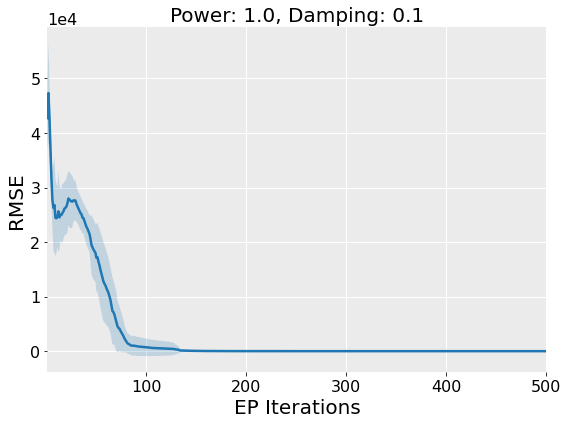

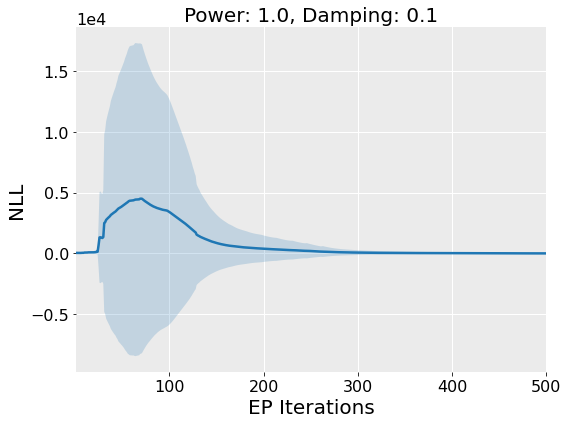

In [388]:
plot_metric_against_iterations(rmse_list, 'rmse')
plt.savefig("figs/Long_iteration_BOT_UT_RMSE.pdf")
plot_metric_against_iterations(nll_list, 'nll')
plt.savefig("figs/Long_iteration_BOT_UT_NLL.pdf")

In [389]:
exp_table = 'UNGM_EXP'
trans = 'TT'
Seeds = np.arange(101, 1101, 100)
con = sqlite3.connect("../Examples/long_iterations_2.db", detect_types=sqlite3.PARSE_DECLTYPES)
cursor = con.cursor()
rmse_list, nll_list = [], []
for seed in Seeds:
    cursor.execute(f"SELECT RMSE FROM UNGM_EXP WHERE Transform = 'TT' AND Seed = {seed} AND Power = 1.0 AND Damping = 0.1")
    data = cursor.fetchall()
    rmse_list.append(np.array(data).squeeze())
    cursor.execute(f"SELECT NLL FROM UNGM_EXP WHERE Transform = 'TT' AND Seed = {seed} AND Power = 1.0 AND Damping = 0.1")
    data = cursor.fetchall()
    nll_list.append(np.array(data).squeeze())

rmse_list = np.array(rmse_list)
nll_list = np.array(nll_list)

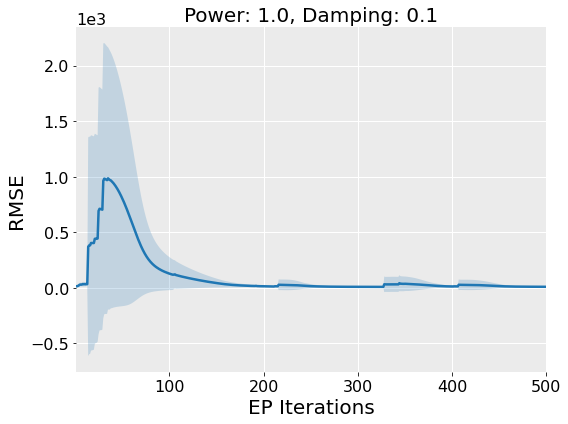

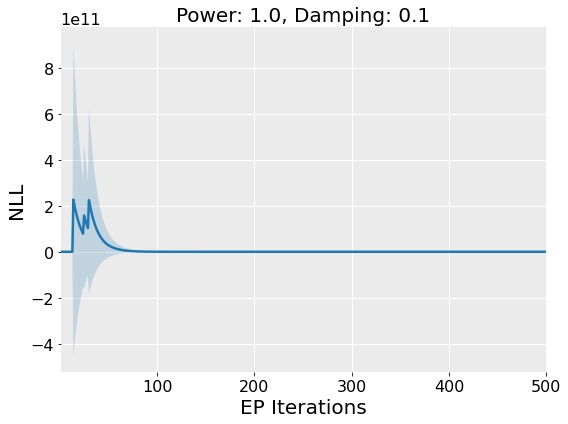

In [390]:
plot_metric_against_iterations(rmse_list, 'rmse')
plt.savefig("figs/Long_iteration_UNGM_TT_RMSE.pdf")
plot_metric_against_iterations(nll_list, 'nll')
plt.savefig("figs/Long_iteration_UNGM_TT_NLL.pdf")